# 06. Force Matching 

In this tutorial, we show how to use force matching to fit a potential energy function to forces from a simulation.

In [1]:
# disable GPU. Remove this if you've compiled HOOMD for GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


import hoomd, hoomd.htf as htf, hoomd.md
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math

## Building the model graph

We build an LJ potential with unknown, trainable parameters (`epsilon`, `sigma`) which start out at 0.9 and 1.1. We then obtain forces from our potential and the simulation. Force matching is used to modify the LJ potential until the forces agree. We use Keras layers to implement the trainable parameters. We'll make our starting parameters $\epsilon=1.2$ and $\sigma=0.9$. The goal is train them to reach $\sigma, \epsilon = 1.0$

In [2]:
class LJLayer(tf.keras.layers.Layer):
    def __init__(self, sig, eps):
        super().__init__(self, name='lj')
        self.start = [sig, eps]
        self.w = self.add_weight(
            shape=[2],
            initializer=tf.constant_initializer([sig, eps]),
            constraint=tf.keras.constraints.NonNeg())

    def call(self, r):
        r6 = tf.math.divide_no_nan(self.w[1]**6, r**6)
        energy = self.w[0] * 4.0 * (r6**2 - r6)
        # divide by 2 to remove double count
        return energy / 2.
    
class TrainableLJ(htf.SimModel):
    def setup(self):
        self.lj = LJLayer(0.9, 1.2)

    def compute(self, nlist):
        # get r
        r = htf.safe_norm(tensor=nlist[:, :, :3], axis=2)
        p_energy = self.lj(r)
        energy = tf.reduce_sum(input_tensor=p_energy, axis=1)
        forces = htf.compute_nlist_forces(nlist, energy)
        return forces, self.lj.w, energy

## Running the simulation

The simulation consists of LJ particles whose sigma and epsilon values are 1.0. Note that when we compile our Keras model, we prevent the loss from looking at our other outputs by using `None`

In [3]:
# run the simulation
N = 256
hoomd.context.initialize('--mode=cpu')

model = TrainableLJ(64, output_forces = False)
model.compile('Adam', loss=['MeanSquaredError', None, None])
tfcompute = htf.tfcompute(model)
rcut = 7.5
system = hoomd.init.create_lattice(
    unitcell=hoomd.lattice.sq(a=4.0),
    n=[int(math.sqrt(N)), int(math.sqrt(N))])
nlist = hoomd.md.nlist.cell(check_period=1)
lj = hoomd.md.pair.lj(r_cut=rcut, nlist=nlist)
lj.pair_coeff.set('A', 'A', epsilon=1, sigma=1)
hoomd.md.integrate.mode_standard(dt=0.005)
hoomd.md.integrate.nve(group=hoomd.group.all(
        )).randomize_velocities(kT=2, seed=2)
tfcompute.attach(nlist, train=True, r_cut=rcut, save_output_period=5)
hoomd.run(1e3)

HOOMD-blue 2.5.2 DOUBLE HPMC_MIXED TBB SSE SSE2 SSE3 
Compiled: 04/30/2019
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 256 particles
notice(2): Force mode is FORCE_MODE.hoomd2tf 
notice(2): Starting TensorflowCompute 
notice(2): completed reallocate
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 256
notice(2): Neighbors included by diameter          

## Plotting training progress

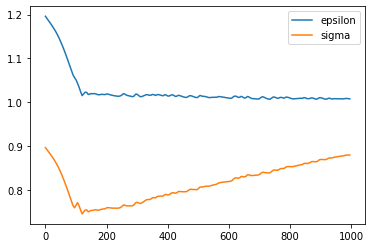

In [4]:
time = range(0, 1000, 5)
epsilon = tfcompute.outputs[0][:,1]
sigma = tfcompute.outputs[0][:,0]
plt.figure()
plt.plot(time, epsilon, label = 'epsilon')
plt.plot(time, sigma, label = 'sigma')
plt.legend()
plt.show()

## Plotting the potential

In [5]:
r = np.linspace(0.2, 4, 1000)
start_model = TrainableLJ(64)
start_vals = htf.compute_pairwise(start_model, r)
end_vals = hoomd.htf.compute_pairwise(model, r)
true_pot = 2 * (r**-12 - r**-6)

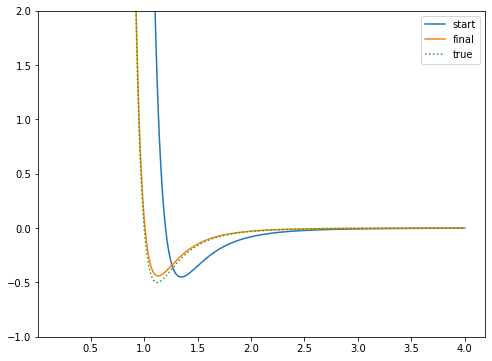

In [6]:
plt.figure(figsize=(8,6))
# is per-particle energy, so grab only 0 particle
plt.plot(r, start_vals[2][:,0], label='start')
plt.plot(r, end_vals[2][:,0], label='final')
plt.plot(r, true_pot, label='true', linestyle=':')
plt.legend()
plt.ylim(-1,2)
plt.show()